In [ ]:
import numpy as np
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization,MaxPooling1D,LSTM,Reshape,TimeDistributed,RepeatVector,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Model
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall

<h3>Data Preparation</h3>

In [ ]:
sys.path.append('/content/mobile-sensing-human-activity-data-set/src')
from utils import load_mosad_dataset
sys.path.append('/content/TCPD/examples/python')
from load_dataset import *
sys.path.append('/content/time-series-segmentation-benchmark/tssb')
from utilsTSSB import load_time_series_segmentation_datasets
sys.path.append('/content/human_activity_segmentation_challenge/notebooks')
from utilsH import load_master_data

In [ ]:
## MOSAD
df_mosad = load_mosad_dataset()
X_mosad,y_mosad=df_mosad.time_series.values,df_mosad.change_points.values ## y is indexes

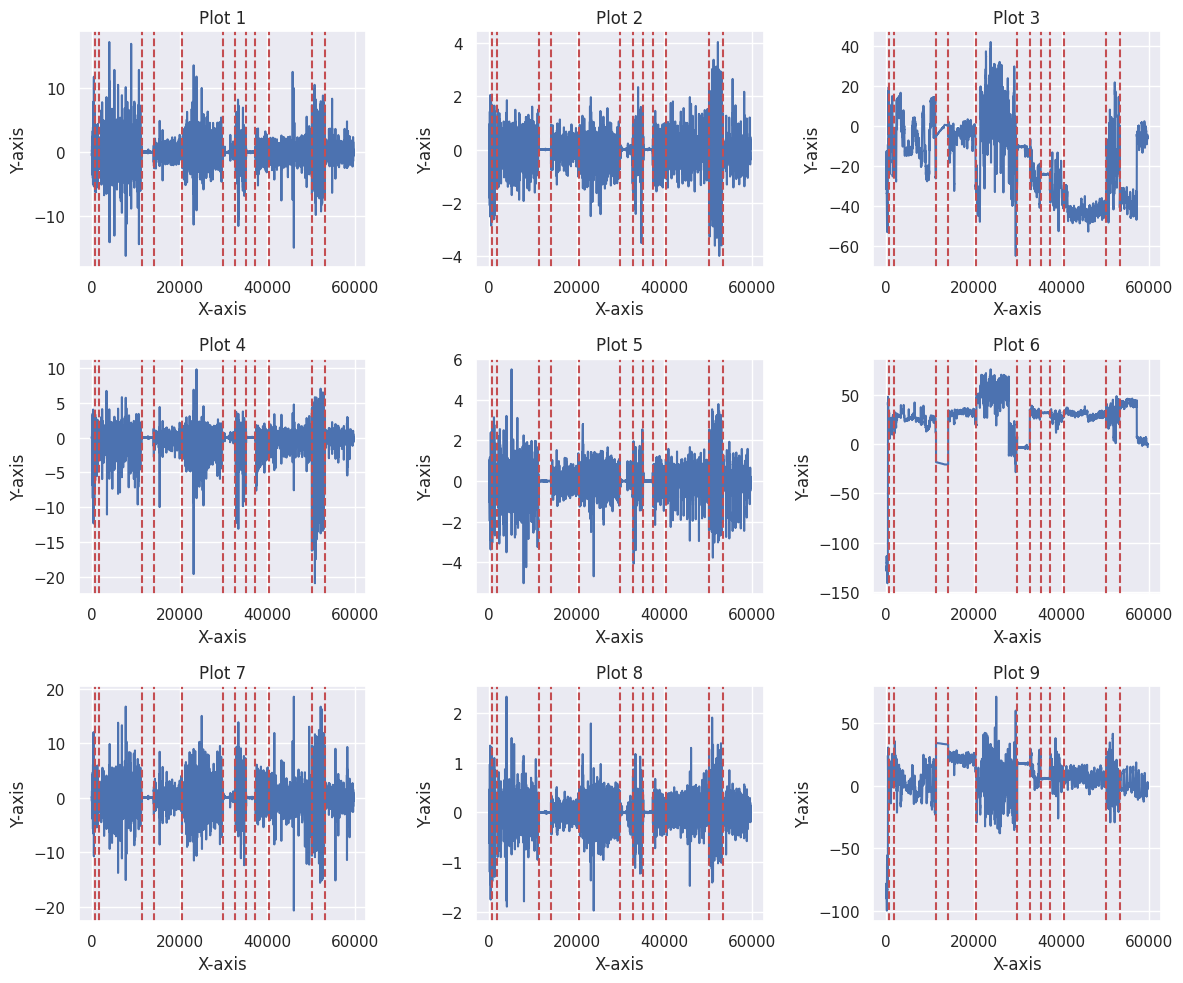

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i in range(9):
    axes[i // 3, i % 3].plot(X_mosad[i])
    for pt in y_mosad[i]:
        axes[i // 3, i % 3].axvline(x=pt, color='r', linestyle='--')
    axes[i // 3, i % 3].set_title(f"Plot {i+1}")
    axes[i // 3, i % 3].set_xlabel("X-axis")
    axes[i // 3, i % 3].set_ylabel("Y-axis")
plt.tight_layout()
plt.show()


In [ ]:
len(X_mosad),len(X_mosad[0]),len(y_mosad),len(y_mosad[0])

(126, 59637, 126, 12)

In [ ]:
## TCPD

# Load JSON data
with open('/content/TCPD/annotations.json') as f:
    data = json.load(f)
rows = []
# Iterate through each key-value pair in the JSON data
for ts_name, ts_data in data.items():
    path_file='/content/TCPD/datasets/'+str(ts_name)+'/'+str(ts_name)+'.json'
    if  os.path.exists(path_file):
        ts = TimeSeries.from_json(path_file)
        ts=ts.df.drop('t',axis="columns").values.reshape(-1)
        change_points = []
        for cp, values in ts_data.items():
            change_points.extend(values)
        # Append a tuple with the required data to the list
        rows.append((ts_name,ts, change_points))

# Create a DataFrame from the list of tuples
tcpd = pd.DataFrame(rows, columns=['ts_name','ts', 'cp'])
tcpd['ts_length']=tcpd.ts.apply(len)

tcpd['cp']=tcpd.cp.apply(lambda x :list(set(x)))
tcpd=tcpd[tcpd.ts_length>=100]
X_tcpd,y_tcpd=tcpd.ts.values,tcpd.cp.values ## indexes

In [ ]:
len(X_tcpd),len(X_tcpd[1]),len(y_tcpd),len(y_tcpd[1])

(24, 500, 24, 26)

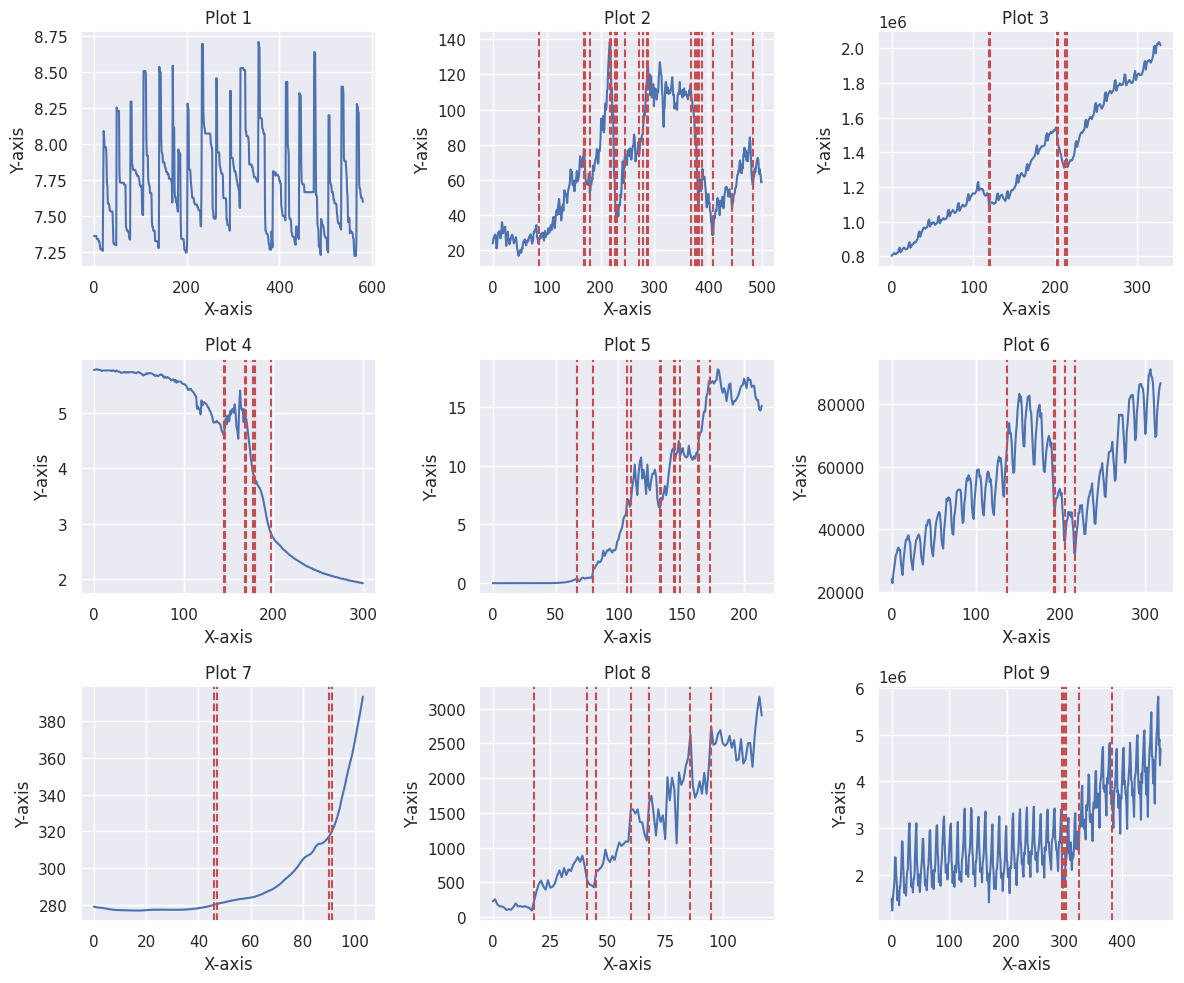

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i in range(9):
    axes[i // 3, i % 3].plot(X_tcpd[i])
    for pt in y_tcpd[i]:
        axes[i // 3, i % 3].axvline(x=pt, color='r', linestyle='--')

    axes[i // 3, i % 3].set_title(f"Plot {i+1}")
    axes[i // 3, i % 3].set_xlabel("X-axis")
    axes[i // 3, i % 3].set_ylabel("Y-axis")

plt.tight_layout()
plt.show()


In [ ]:
## TSSB
tssb = load_time_series_segmentation_datasets()
X_tssb,y_tssb=tssb.time_series.values,tssb.change_points.values ## indexes

In [ ]:
len(X_tssb),len(X_tssb[0]),len(y_tssb),len(y_tssb[0])

(75, 1408, 75, 3)

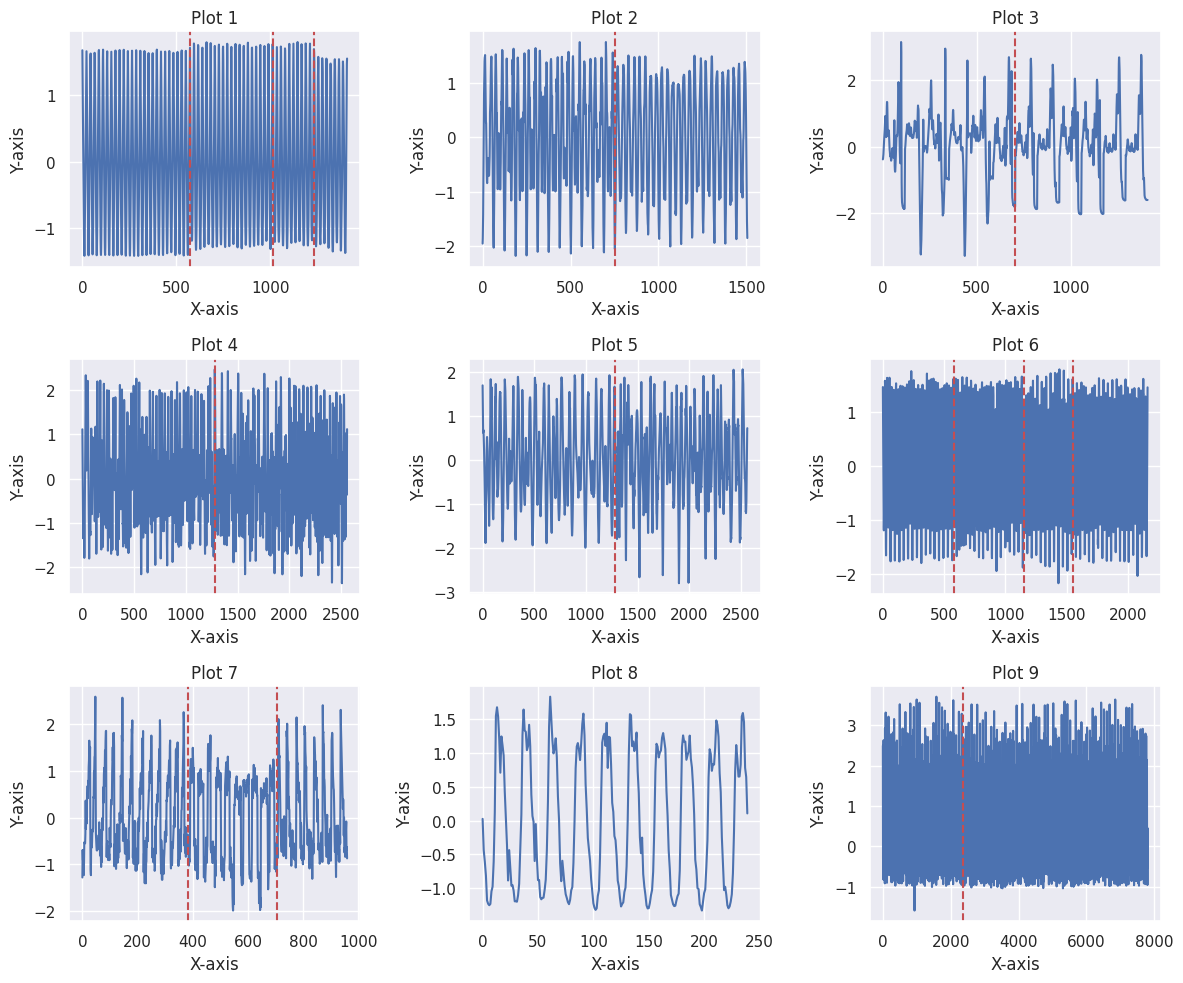

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i in range(9):
    axes[i // 3, i % 3].plot(X_tssb[i])
    for pt in y_tssb[i]:
        axes[i // 3, i % 3].axvline(x=pt, color='r', linestyle='--')

    axes[i // 3, i % 3].set_title(f"Plot {i+1}")
    axes[i // 3, i % 3].set_xlabel("X-axis")
    axes[i // 3, i % 3].set_ylabel("Y-axis")

plt.tight_layout()
plt.show()


In [ ]:
## SKAB
path_to_data = '/content/SKAB'
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# datasets with anomalies loading
skab = [pd.read_csv(file,
                          sep=';',
                        #   index_col='datetime',
                          parse_dates=True).drop('anomaly', axis=1) for file in all_files if 'anomaly-free' not in file]
X_skab,y_skab=[el.Accelerometer2RMS.values for el in skab],[el.changepoint.values for el in skab] ## 0 or 1

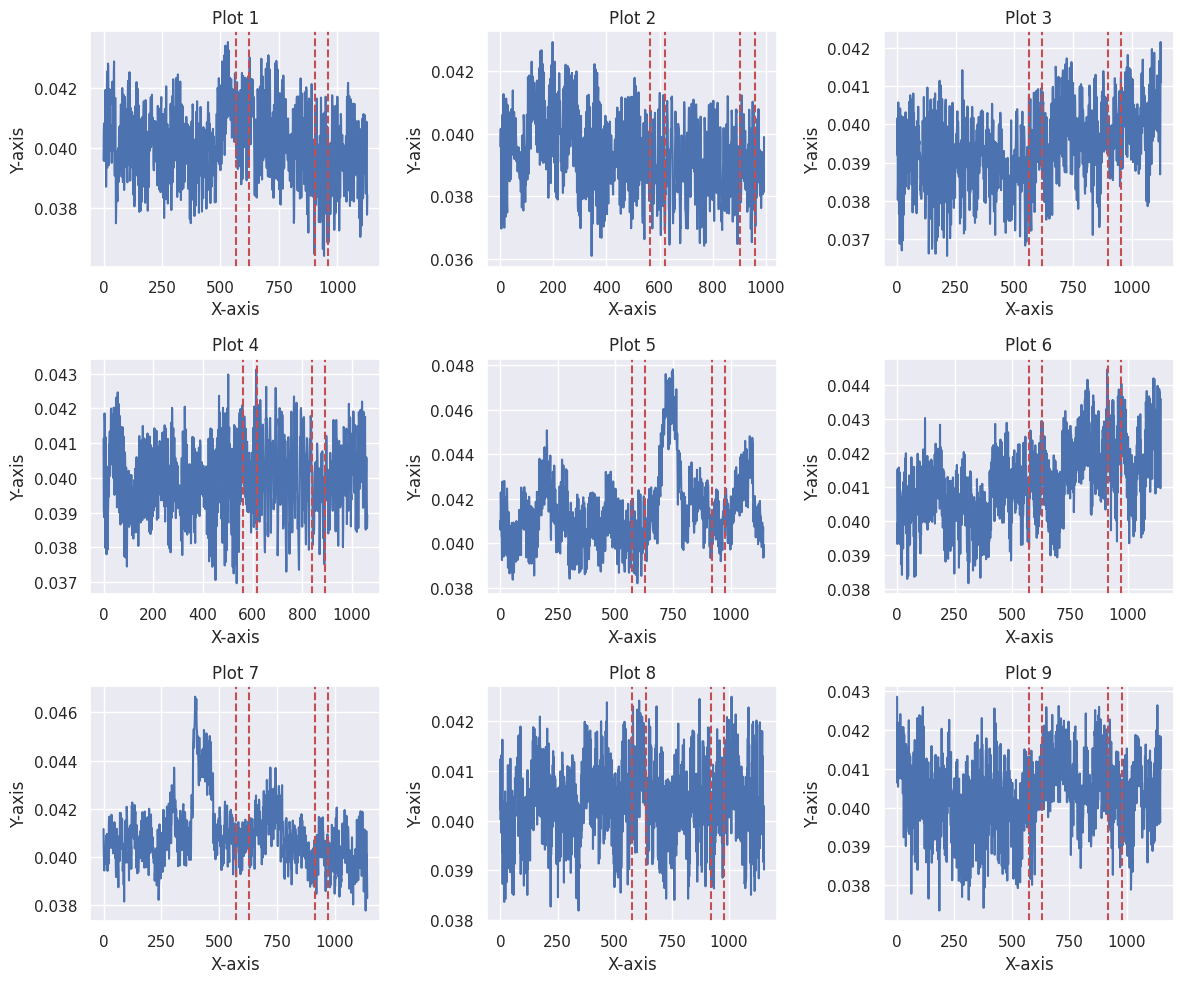

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i in range(9):
    axes[i // 3, i % 3].plot(X_skab[i])
    for _,pt in enumerate(y_skab[i]):
      if pt==1.0:
        axes[i // 3, i % 3].axvline(x=_, color='r', linestyle='--')

    axes[i // 3, i % 3].set_title(f"Plot {i+1}")
    axes[i // 3, i % 3].set_xlabel("X-axis")
    axes[i // 3, i % 3].set_ylabel("Y-axis")

plt.tight_layout()
plt.show()


In [ ]:
df = load_master_data("/content/human_activity_segmentation_challenge/datasets/has2023_master.csv.zip")
cols = [5,14]
df=df[df.columns[cols]]
X_human=df["x-mag"].values
y_human=df["change_points"].values

In [ ]:
len(X_human),len(X_human[1]),len(y_human),len(y_human[1])

(250, 8330, 250, 6)

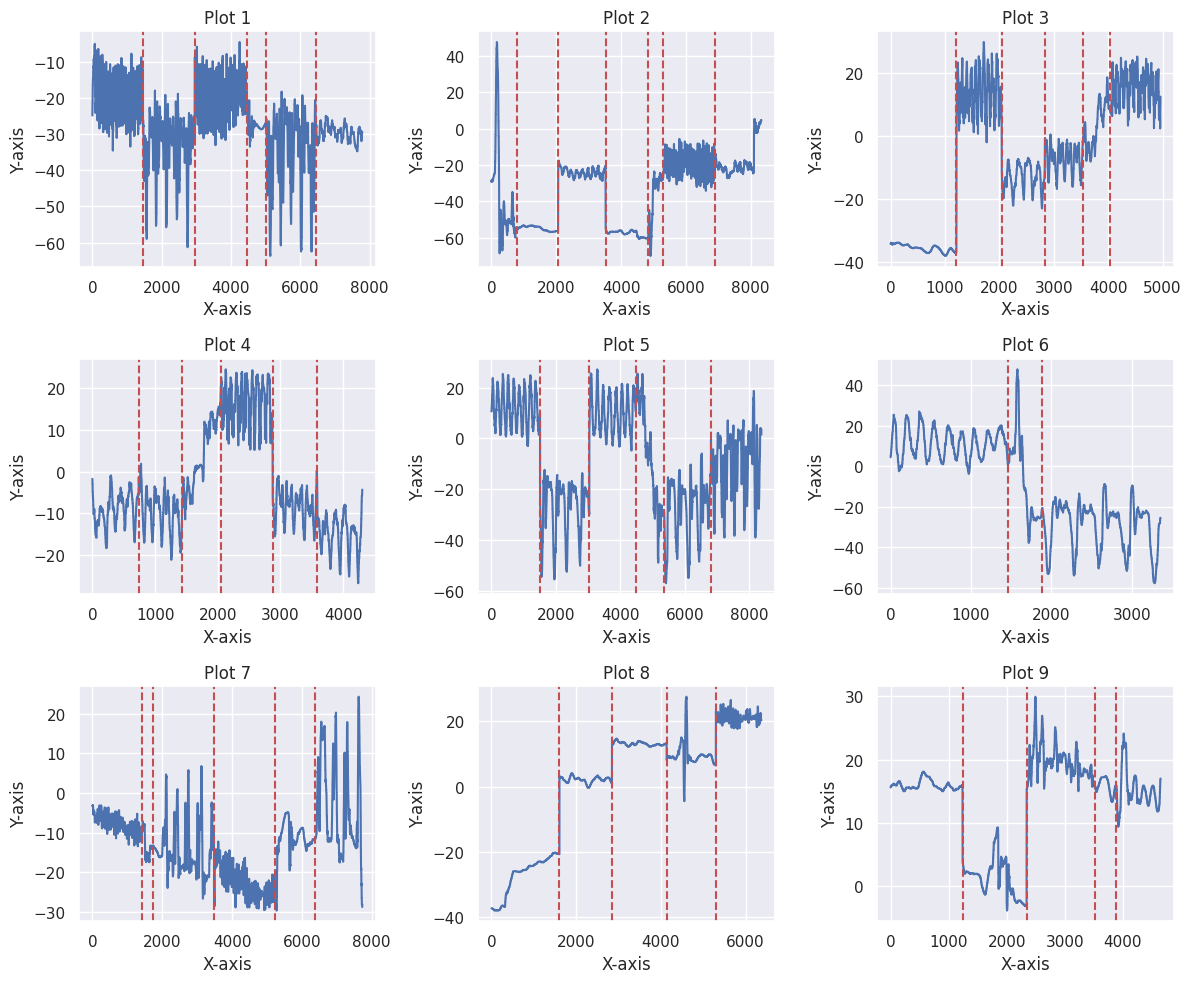

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i in range(9):
    axes[i // 3, i % 3].plot(X_human[i])
    for pt in y_human[i]:
        axes[i // 3, i % 3].axvline(x=pt, color='r', linestyle='--')

    axes[i // 3, i % 3].set_title(f"Plot {i+1}")
    axes[i // 3, i % 3].set_xlabel("X-axis")
    axes[i // 3, i % 3].set_ylabel("Y-axis")

plt.tight_layout()
plt.show()


In [ ]:
# X=list(X_human)+list(X_mosad)+list(X_tcpd)+list(X_tssb)
# y=list(y_human)+list(y_mosad)+list(y_tcpd)+list(y_tssb)
# X=list(X_mosad)+list(X_human)
# y=list(y_mosad)+list(y_human)
# len(X),len(y)

<h2>Vanilla LSTM</h2>

In [ ]:
class Vanilla_LSTM:

    def __init__(self, params):
        self.params = params

    def _Random(self, seed_value):

        import os
        os.environ['PYTHONHASHSEED'] = str(seed_value)

        import random
        random.seed(seed_value)

        import numpy as np
        np.random.seed(seed_value)

        import tensorflow as tf
        tf.random.set_seed(seed_value)

    def _build_model(self):
        self._Random(0)

        model = Sequential()
        model.add(LSTM(100,
                       activation='relu',
                       return_sequences=True,
                       input_shape=(self.params[0], self.n_features)))
        model.add(LSTM(100,
                       activation='relu'))
        model.add(Dense(self.n_features))
        model.compile(optimizer='adam',
                      loss='mae',
                      metrics=["mse"])
        return model

    def fit(self, X, y):

        self.n_features = X.shape[2]
        self.model = self._build_model()

        early_stopping = EarlyStopping(patience=10,
                                       verbose=0)

        reduce_lr = ReduceLROnPlateau(factor=0.1,
                                      patience=5,
                                      min_lr=0.0001,
                                      verbose=0)

        self.model.fit(X, y,
                  validation_split=self.params[3],
                  epochs=self.params[1],
                  batch_size=self.params[2],
                  verbose=0,
                  shuffle=False,
                  callbacks=[early_stopping, reduce_lr]
                  )

    def predict(self, data):

        return self.model.predict(data)


In [ ]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def filter_changepoints(changepoints, min_distance):
    if len(changepoints) == 0:
        return []

    # Initialize filtered changepoints with the first detected changepoint
    filtered_changepoints = [changepoints[0]]

    for cp in changepoints[1:]:
        if cp - filtered_changepoints[-1] >= min_distance:
            filtered_changepoints.append(cp)

    return filtered_changepoints

In [ ]:
def get_cps_ts(ts,N_STEPS = 5,EPOCHS = 25,BATCH_SIZE = 32,VAL_SPLIT = 0.2,Q = 0.99,min_distance=20 ):
  # hyperparameters selection
  PARAMS = [N_STEPS, EPOCHS, BATCH_SIZE, VAL_SPLIT]


  x=ts[:len(ts)//2].reshape(-1,1)
  StSc = StandardScaler()
  StSc.fit(x)
  X, y = split_sequences(StSc.transform(x), N_STEPS)
  model=Vanilla_LSTM(PARAMS)
  model.fit(X, y)
  # results predicting
  X, y = split_sequences(StSc.transform(ts.reshape(-1,1)), N_STEPS)

  residuals_train = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
  UCL = residuals_train.quantile(Q) * 5

  # results predicting
  lstm_residuals = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
  prediction = pd.Series((lstm_residuals > UCL).astype(int).values,
                              index=range(len(ts)-N_STEPS)).fillna(0)



  # predicted CPs saving
  prediction_cp = abs(prediction.diff())
  prediction_cp[0] = prediction[0]
  cps=np.where(prediction_cp.values==1.0)[0]
  cps=filter_changepoints(cps,min_distance)
  return cps


<h3>Test on TSSB</h3>

In [ ]:
yp=[]
for i,ts in tqdm(enumerate(X_tssb)):
  cps=get_cps_ts(ts,Q=.87)
  cps=filter_changepoints(cps,20)
  yp.append(cps)
  # print(i,cps,y_tssb[i])


0it [00:00, ?it/s]

44/44 [==============================] - 0s 5ms/step


1it [00:11, 11.09s/it]

47/47 [==============================] - 0s 4ms/step


2it [00:31, 16.64s/it]

44/44 [==============================] - 0s 8ms/step


3it [00:45, 15.30s/it]

80/80 [==============================] - 0s 4ms/step


4it [01:01, 15.48s/it]

80/80 [==============================] - 0s 4ms/step


5it [01:15, 15.22s/it]

68/68 [==============================] - 0s 4ms/step


6it [01:29, 14.76s/it]

30/30 [==============================] - 0s 4ms/step


7it [01:38, 12.75s/it]

8/8 [==============================] - 0s 4ms/step


8it [01:43, 10.23s/it]

244/244 [==============================] - 1s 5ms/step


9it [02:30, 21.98s/it]

224/224 [==============================] - 1s 4ms/step


10it [03:03, 25.16s/it]

32/32 [==============================] - 0s 4ms/step


11it [03:12, 20.16s/it]

352/352 [==============================] - 2s 4ms/step


12it [03:58, 28.14s/it]

97/97 [==============================] - 0s 4ms/step


13it [04:08, 22.64s/it]

96/96 [==============================] - 0s 4ms/step


14it [04:23, 20.49s/it]

85/85 [==============================] - 0s 4ms/step


15it [04:38, 18.68s/it]

647/647 [==============================] - 3s 4ms/step


16it [05:46, 33.41s/it]

41/41 [==============================] - 0s 4ms/step


17it [05:55, 26.09s/it]

45/45 [==============================] - 0s 5ms/step


18it [06:04, 20.92s/it]

81/81 [==============================] - 0s 4ms/step


19it [06:19, 19.25s/it]

108/108 [==============================] - 0s 4ms/step


20it [06:35, 18.45s/it]

75/75 [==============================] - 0s 4ms/step


21it [06:50, 17.18s/it]

25/25 [==============================] - 0s 4ms/step


22it [07:03, 16.08s/it]

161/161 [==============================] - 1s 4ms/step


23it [07:28, 18.67s/it]

251/251 [==============================] - 1s 4ms/step


24it [08:00, 22.77s/it]

287/287 [==============================] - 1s 5ms/step


25it [08:49, 30.66s/it]

263/263 [==============================] - 1s 4ms/step


26it [09:36, 35.35s/it]

203/203 [==============================] - 1s 4ms/step


27it [10:01, 32.40s/it]

163/163 [==============================] - 1s 4ms/step


28it [10:17, 27.54s/it]

317/317 [==============================] - 1s 4ms/step


29it [11:02, 32.53s/it]

353/353 [==============================] - 1s 4ms/step


30it [11:51, 37.62s/it]

184/184 [==============================] - 1s 4ms/step


31it [12:17, 34.27s/it]

156/156 [==============================] - 1s 4ms/step


32it [12:41, 30.91s/it]

59/59 [==============================] - 0s 4ms/step


33it [12:54, 25.76s/it]

184/184 [==============================] - 1s 4ms/step


34it [13:40, 31.70s/it]

151/151 [==============================] - 1s 4ms/step


35it [14:06, 29.91s/it]

40/40 [==============================] - 0s 4ms/step


36it [14:15, 23.86s/it]

51/51 [==============================] - 0s 4ms/step


37it [14:26, 20.00s/it]

264/264 [==============================] - 1s 4ms/step


38it [15:13, 28.04s/it]

38/38 [==============================] - 0s 5ms/step


39it [15:29, 24.50s/it]

205/205 [==============================] - 1s 4ms/step


40it [16:16, 31.21s/it]

124/124 [==============================] - 1s 5ms/step


41it [16:42, 29.60s/it]

105/105 [==============================] - 0s 4ms/step


42it [16:59, 25.91s/it]

78/78 [==============================] - 0s 4ms/step


43it [17:13, 22.26s/it]

153/153 [==============================] - 1s 4ms/step


44it [17:39, 23.25s/it]

323/323 [==============================] - 1s 4ms/step


45it [18:23, 29.68s/it]

248/248 [==============================] - 1s 4ms/step


46it [18:50, 28.92s/it]

210/210 [==============================] - 1s 5ms/step


47it [19:37, 34.30s/it]

53/53 [==============================] - 0s 7ms/step


48it [19:52, 28.56s/it]

388/388 [==============================] - 2s 5ms/step


49it [21:22, 46.96s/it]

441/441 [==============================] - 2s 5ms/step


50it [22:56, 61.06s/it]

232/232 [==============================] - 1s 4ms/step


51it [23:30, 52.84s/it]

65/65 [==============================] - 0s 4ms/step


52it [23:39, 39.76s/it]

118/118 [==============================] - 0s 4ms/step


53it [23:57, 33.26s/it]

125/125 [==============================] - 0s 4ms/step


54it [24:17, 29.23s/it]

188/188 [==============================] - 1s 4ms/step


55it [24:43, 28.31s/it]

125/125 [==============================] - 1s 4ms/step


56it [25:09, 27.51s/it]

200/200 [==============================] - 1s 4ms/step


57it [25:36, 27.35s/it]

78/78 [==============================] - 0s 4ms/step


58it [25:45, 21.82s/it]

44/44 [==============================] - 0s 5ms/step


59it [26:00, 19.83s/it]

55/55 [==============================] - 0s 4ms/step


60it [26:11, 17.16s/it]

186/186 [==============================] - 1s 4ms/step


61it [26:36, 19.65s/it]

136/136 [==============================] - 1s 4ms/step


62it [27:00, 20.89s/it]

59/59 [==============================] - 0s 4ms/step


63it [27:13, 18.38s/it]

118/118 [==============================] - 0s 4ms/step


64it [27:27, 17.19s/it]

87/87 [==============================] - 0s 4ms/step


65it [27:42, 16.44s/it]

97/97 [==============================] - 0s 4ms/step


66it [27:57, 16.09s/it]

159/159 [==============================] - 1s 4ms/step


67it [28:21, 18.50s/it]

15/15 [==============================] - 0s 6ms/step


68it [28:27, 14.70s/it]

57/57 [==============================] - 0s 4ms/step


69it [28:38, 13.57s/it]

265/265 [==============================] - 1s 4ms/step


70it [29:12, 19.84s/it]

88/88 [==============================] - 0s 5ms/step


71it [29:22, 16.77s/it]

88/88 [==============================] - 0s 4ms/step


72it [29:32, 14.73s/it]

88/88 [==============================] - 0s 4ms/step


73it [29:47, 14.86s/it]

75/75 [==============================] - 0s 6ms/step


74it [30:03, 15.08s/it]

500/500 [==============================] - 2s 4ms/step


75it [31:33, 25.24s/it]


In [ ]:
all_ts_len=[]
for y in X_tssb:
  all_ts_len.append(len(y))

In [ ]:
evaluate_and_save(y_tssb,yp,all_ts_len,"tssb")

<ipython-input-30-ee2838bc01ff>:378: RuntimeWarning: invalid value encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
<ipython-input-30-ee2838bc01ff>:378: RuntimeWarning: invalid value encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
<ipython-input-30-ee2838bc01ff>:378: RuntimeWarning: invalid value encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
<ipython-input-30-ee2838bc01ff>:378: RuntimeWarning: divide by zero encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)


Mean Covering: 0.37593351123458824
Mean F-measure: 0.41579332261136
Mean NAB (Standard): -28.566956521739137
Mean NAB (LowFP): -104.51217391304348
Mean NAB (LowFN): -3.243623188405799


<ipython-input-30-ee2838bc01ff>:378: RuntimeWarning: invalid value encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
<ipython-input-30-ee2838bc01ff>:378: RuntimeWarning: divide by zero encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)


<h3>Test on MOSAD</h3>

In [ ]:
yp=[]
for i,ts in tqdm(enumerate(X_mosad)):
  cps=get_cps_ts(ts,Q=.87)
  cps=filter_changepoints(cps,20)
  yp.append(cps)
  # print(i,cps,y_mosad[i])


0it [00:00, ?it/s]

1864/1864 [==============================] - 8s 4ms/step


1it [03:46, 226.03s/it]

1864/1864 [==============================] - 7s 4ms/step


2it [07:02, 208.49s/it]

1864/1864 [==============================] - 8s 4ms/step


3it [10:45, 215.32s/it]

1864/1864 [==============================] - 8s 4ms/step


4it [14:28, 218.08s/it]

1864/1864 [==============================] - 8s 4ms/step


5it [18:13, 220.63s/it]

1864/1864 [==============================] - 9s 5ms/step


6it [21:57, 221.77s/it]

1864/1864 [==============================] - 8s 5ms/step


7it [25:40, 222.20s/it]

1864/1864 [==============================] - 7s 4ms/step


8it [29:25, 223.25s/it]

1864/1864 [==============================] - 8s 4ms/step


9it [34:11, 242.90s/it]

1881/1881 [==============================] - 9s 5ms/step


10it [38:54, 255.23s/it]

1881/1881 [==============================] - 8s 4ms/step


11it [43:38, 263.90s/it]

1881/1881 [==============================] - 8s 4ms/step


12it [48:23, 270.27s/it]

1881/1881 [==============================] - 8s 4ms/step


13it [52:01, 254.69s/it]

1881/1881 [==============================] - 8s 4ms/step


14it [56:48, 264.21s/it]

1881/1881 [==============================] - 9s 5ms/step


15it [1:00:46, 256.34s/it]

1881/1881 [==============================] - 9s 5ms/step


16it [1:04:30, 246.60s/it]

1881/1881 [==============================] - 9s 5ms/step


17it [1:08:13, 239.72s/it]

1881/1881 [==============================] - 9s 5ms/step


18it [1:12:08, 238.04s/it]

1795/1795 [==============================] - 9s 5ms/step


19it [1:16:53, 252.22s/it]

1795/1795 [==============================] - 8s 4ms/step


20it [1:21:36, 261.60s/it]

1795/1795 [==============================] - 8s 5ms/step


21it [1:25:25, 251.65s/it]

1795/1795 [==============================] - 8s 4ms/step


22it [1:30:10, 261.89s/it]

1795/1795 [==============================] - 7s 4ms/step


23it [1:33:54, 250.31s/it]

1795/1795 [==============================] - 8s 4ms/step


24it [1:37:39, 242.71s/it]

1795/1795 [==============================] - 9s 5ms/step


25it [1:41:23, 237.28s/it]

1795/1795 [==============================] - 7s 4ms/step


26it [1:45:06, 232.83s/it]

1795/1795 [==============================] - 8s 4ms/step


27it [1:48:49, 229.84s/it]

1836/1836 [==============================] - 8s 4ms/step


28it [1:53:33, 246.07s/it]

1836/1836 [==============================] - 8s 4ms/step


29it [1:57:19, 240.26s/it]

1836/1836 [==============================] - 9s 5ms/step


30it [2:02:04, 253.50s/it]

1836/1836 [==============================] - 9s 5ms/step


31it [2:06:49, 263.14s/it]

1836/1836 [==============================] - 8s 4ms/step


32it [2:10:31, 250.68s/it]

1836/1836 [==============================] - 8s 5ms/step


33it [2:14:16, 243.12s/it]

1836/1836 [==============================] - 10s 5ms/step


34it [2:19:23, 262.03s/it]

1836/1836 [==============================] - 10s 6ms/step


35it [2:23:41, 260.98s/it]

1836/1836 [==============================] - 11s 6ms/step


36it [2:29:31, 249.22s/it]


KeyboardInterrupt: 

In [ ]:
all_ts_len=[]
for i,y in enumerate(X_mosad):
  if i>=len(yp):
    break
  all_ts_len.append(len(y))

In [ ]:
evaluate_and_save(y_mosad,yp,all_ts_len,"MOSAD")

Mean Covering: 0.40672158686391235
Mean F-measure: 0.18465848503516546
Mean NAB (Standard): 4.547222222222223
Mean NAB (LowFP): -81.18666666666667
Mean NAB (LowFN): 33.277777777777786


In [ ]:
results

{'MOSAD': {'Covering': 0.40672158686391235,
  'F-measure': 0.18465848503516546,
  'NAB (Standard)': 4.547222222222223,
  'NAB (LowFP)': -81.18666666666667,
  'NAB (LowFN)': 33.277777777777786}}

In [ ]:
 results

{'BinaryClaSPSegmentation': {'Covering': 0.37593351123458824,
  'F-measure': 0.41579332261136,
  'NAB (Standard)': -28.566956521739137,
  'NAB (LowFP)': -104.51217391304348,
  'NAB (LowFN)': -3.243623188405799},
 'MOSAD': {'Covering': 0.39989370227417237,
  'F-measure': 0.17950868361530328,
  'NAB (Standard)': 3.0126315789473694,
  'NAB (LowFP)': -84.49815789473685,
  'NAB (LowFN)': 32.34421052631579}}

In [ ]:
len(all_ts_len),len(X_mosad)

(38, 126)

<h3>Test on hUMAN ACTIVITY</h3>

In [ ]:
yp=[]
for i,ts in tqdm(enumerate(X_human)):
  cps=get_cps_ts(ts,Q=.87)
  cps=filter_changepoints(cps,20)
  yp.append(cps)


0it [00:00, ?it/s]

244/244 [==============================] - 1s 4ms/step


1it [00:48, 48.86s/it]

261/261 [==============================] - 1s 6ms/step


2it [01:21, 39.59s/it]

155/155 [==============================] - 1s 4ms/step


3it [01:45, 32.44s/it]

135/135 [==============================] - 1s 6ms/step


4it [02:01, 25.94s/it]

262/262 [==============================] - 1s 4ms/step


5it [02:49, 33.65s/it]

105/105 [==============================] - 0s 4ms/step


6it [03:06, 28.18s/it]

242/242 [==============================] - 1s 4ms/step


7it [03:42, 30.76s/it]

200/200 [==============================] - 1s 4ms/step


8it [04:08, 29.23s/it]

146/146 [==============================] - 1s 4ms/step


9it [04:31, 27.33s/it]

181/181 [==============================] - 1s 5ms/step


10it [04:58, 27.15s/it]

175/175 [==============================] - 1s 5ms/step


11it [05:26, 27.26s/it]

107/107 [==============================] - 0s 4ms/step


12it [05:52, 26.88s/it]

188/188 [==============================] - 1s 6ms/step


13it [06:21, 27.62s/it]

169/169 [==============================] - 1s 4ms/step


14it [06:47, 27.03s/it]

186/186 [==============================] - 1s 5ms/step


15it [07:12, 26.63s/it]

145/145 [==============================] - 1s 6ms/step


16it [07:36, 25.76s/it]

137/137 [==============================] - 1s 7ms/step


17it [08:02, 25.93s/it]

196/196 [==============================] - 1s 6ms/step


18it [08:31, 26.67s/it]

156/156 [==============================] - 1s 5ms/step


19it [08:57, 26.57s/it]

135/135 [==============================] - 1s 4ms/step


20it [09:19, 25.24s/it]

141/141 [==============================] - 1s 4ms/step


21it [09:45, 25.39s/it]

154/154 [==============================] - 1s 5ms/step


22it [10:10, 25.40s/it]

130/130 [==============================] - 1s 6ms/step


23it [10:33, 24.59s/it]

87/87 [==============================] - 0s 5ms/step


24it [10:59, 24.83s/it]

102/102 [==============================] - 0s 4ms/step


25it [11:17, 22.84s/it]

94/94 [==============================] - 0s 4ms/step


26it [11:33, 20.90s/it]

179/179 [==============================] - 1s 6ms/step


27it [12:20, 28.65s/it]

171/171 [==============================] - 1s 4ms/step


28it [13:06, 33.90s/it]

362/362 [==============================] - 2s 5ms/step


29it [14:36, 50.59s/it]

351/351 [==============================] - 2s 4ms/step


30it [15:20, 48.69s/it]

234/234 [==============================] - 1s 5ms/step


31it [16:09, 48.78s/it]

260/260 [==============================] - 1s 5ms/step


32it [16:45, 45.11s/it]

246/246 [==============================] - 1s 4ms/step


33it [17:32, 45.49s/it]

249/249 [==============================] - 1s 4ms/step


34it [18:19, 46.15s/it]

170/170 [==============================] - 1s 4ms/step


35it [18:46, 40.28s/it]

103/103 [==============================] - 0s 4ms/step


36it [19:03, 33.40s/it]

327/327 [==============================] - 2s 5ms/step


37it [19:48, 36.79s/it]

480/480 [==============================] - 2s 5ms/step


38it [20:53, 45.27s/it]

285/285 [==============================] - 1s 5ms/step


39it [21:41, 46.18s/it]

324/324 [==============================] - 2s 6ms/step


40it [22:32, 47.43s/it]

261/261 [==============================] - 1s 4ms/step


41it [23:08, 44.18s/it]

218/218 [==============================] - 1s 4ms/step


42it [23:42, 40.96s/it]

259/259 [==============================] - 1s 4ms/step


43it [24:17, 39.27s/it]

114/114 [==============================] - 1s 4ms/step


44it [24:43, 35.22s/it]

491/491 [==============================] - 2s 4ms/step


45it [26:14, 51.94s/it]

429/429 [==============================] - 2s 5ms/step


46it [27:12, 53.84s/it]

124/124 [==============================] - 1s 5ms/step


47it [27:38, 45.42s/it]

284/284 [==============================] - 1s 5ms/step


48it [28:18, 43.86s/it]

157/157 [==============================] - 1s 4ms/step


49it [28:44, 38.50s/it]

167/167 [==============================] - 1s 4ms/step


50it [29:12, 35.41s/it]

245/245 [==============================] - 1s 4ms/step


51it [30:00, 39.08s/it]

155/155 [==============================] - 1s 4ms/step


52it [30:25, 34.76s/it]

325/325 [==============================] - 1s 4ms/step


53it [31:09, 37.71s/it]

463/463 [==============================] - 3s 6ms/step


54it [32:12, 45.19s/it]

158/158 [==============================] - 1s 6ms/step


55it [32:38, 39.52s/it]

364/364 [==============================] - 2s 4ms/step


56it [33:27, 42.47s/it]

317/317 [==============================] - 1s 4ms/step


57it [34:16, 44.15s/it]

411/411 [==============================] - 2s 4ms/step


58it [35:49, 58.80s/it]

583/583 [==============================] - 3s 5ms/step


59it [37:11, 65.91s/it]

291/291 [==============================] - 1s 4ms/step


60it [37:54, 58.97s/it]

396/396 [==============================] - 2s 5ms/step


61it [39:25, 68.51s/it]

113/113 [==============================] - 1s 5ms/step


62it [39:47, 54.65s/it]

212/212 [==============================] - 1s 6ms/step


63it [40:35, 52.82s/it]

141/141 [==============================] - 1s 6ms/step


64it [41:01, 44.64s/it]

198/198 [==============================] - 1s 6ms/step


65it [41:27, 39.17s/it]

64/64 [==============================] - 0s 5ms/step


66it [41:43, 32.08s/it]

80/80 [==============================] - 0s 5ms/step


67it [41:59, 27.38s/it]

129/129 [==============================] - 1s 6ms/step


68it [42:26, 27.02s/it]

141/141 [==============================] - 1s 6ms/step


69it [42:41, 23.51s/it]

213/213 [==============================] - 1s 6ms/step


70it [43:28, 30.74s/it]

255/255 [==============================] - 1s 6ms/step


71it [44:10, 34.09s/it]

179/179 [==============================] - 1s 5ms/step


72it [44:39, 32.34s/it]

185/185 [==============================] - 1s 5ms/step


73it [45:25, 36.60s/it]

79/79 [==============================] - 1s 6ms/step


74it [45:42, 30.53s/it]

85/85 [==============================] - 0s 4ms/step


75it [46:07, 28.88s/it]

167/167 [==============================] - 1s 6ms/step


76it [46:54, 34.39s/it]

208/208 [==============================] - 1s 6ms/step


77it [47:44, 39.26s/it]

319/319 [==============================] - 2s 6ms/step


78it [48:33, 42.19s/it]

233/233 [==============================] - 1s 5ms/step


79it [49:06, 39.40s/it]

80/80 [==============================] - 1s 6ms/step


80it [49:23, 32.55s/it]

131/131 [==============================] - 1s 6ms/step


81it [49:49, 30.63s/it]

268/268 [==============================] - 2s 7ms/step


82it [50:23, 31.59s/it]

115/115 [==============================] - 1s 6ms/step


83it [50:50, 30.21s/it]

473/473 [==============================] - 3s 6ms/step


84it [52:21, 48.48s/it]

258/258 [==============================] - 1s 4ms/step


85it [53:08, 48.01s/it]

259/259 [==============================] - 1s 4ms/step


86it [53:55, 47.89s/it]

199/199 [==============================] - 1s 4ms/step


87it [54:25, 42.41s/it]

112/112 [==============================] - 0s 4ms/step


88it [54:50, 37.16s/it]

139/139 [==============================] - 1s 4ms/step


89it [55:12, 32.74s/it]

156/156 [==============================] - 1s 6ms/step


90it [55:36, 30.02s/it]

118/118 [==============================] - 1s 6ms/step


91it [55:48, 24.64s/it]

87/87 [==============================] - 0s 5ms/step


92it [56:05, 22.37s/it]

64/64 [==============================] - 0s 4ms/step


93it [56:19, 19.70s/it]

48/48 [==============================] - 0s 6ms/step


94it [56:32, 17.71s/it]

47/47 [==============================] - 0s 5ms/step


95it [56:47, 16.92s/it]

15/15 [==============================] - 0s 5ms/step


96it [56:56, 14.53s/it]

36/36 [==============================] - 0s 5ms/step


97it [57:05, 12.86s/it]

429/429 [==============================] - 2s 5ms/step


98it [58:36, 36.42s/it]

219/219 [==============================] - 1s 5ms/step


99it [59:08, 35.18s/it]

222/222 [==============================] - 1s 5ms/step


100it [59:49, 36.75s/it]

30/30 [==============================] - 0s 4ms/step


101it [1:00:03, 29.96s/it]

143/143 [==============================] - 1s 4ms/step


102it [1:00:30, 28.92s/it]

32/32 [==============================] - 0s 6ms/step


103it [1:00:40, 23.44s/it]

108/108 [==============================] - 1s 6ms/step


104it [1:01:05, 23.97s/it]

134/134 [==============================] - 1s 5ms/step


105it [1:01:32, 24.73s/it]

319/319 [==============================] - 2s 6ms/step


106it [1:03:02, 44.31s/it]

241/241 [==============================] - 2s 8ms/step


107it [1:03:50, 45.50s/it]

506/506 [==============================] - 3s 6ms/step


108it [1:04:57, 51.83s/it]

548/548 [==============================] - 3s 6ms/step


109it [1:06:30, 64.32s/it]

424/424 [==============================] - 3s 6ms/step


110it [1:07:45, 67.33s/it]

45/45 [==============================] - 0s 6ms/step


111it [1:07:56, 50.44s/it]

132/132 [==============================] - 1s 7ms/step


112it [1:08:24, 43.70s/it]

108/108 [==============================] - 1s 8ms/step


113it [1:08:51, 38.86s/it]

474/474 [==============================] - 4s 9ms/step


114it [1:10:35, 58.39s/it]

86/86 [==============================] - 1s 7ms/step


115it [1:10:57, 47.57s/it]

241/241 [==============================] - 2s 8ms/step


116it [1:11:32, 43.82s/it]

317/317 [==============================] - 2s 7ms/step


117it [1:13:07, 59.15s/it]

262/262 [==============================] - 2s 8ms/step


118it [1:14:03, 58.18s/it]

12/12 [==============================] - 0s 9ms/step


119it [1:14:12, 43.25s/it]

167/167 [==============================] - 1s 7ms/step


120it [1:15:02, 45.31s/it]

99/99 [==============================] - 1s 8ms/step


121it [1:15:21, 37.50s/it]

797/797 [==============================] - 6s 8ms/step


122it [1:17:27, 63.95s/it]

996/996 [==============================] - 6s 6ms/step


123it [1:20:13, 94.63s/it]

91/91 [==============================] - 1s 6ms/step


124it [1:20:38, 73.82s/it]

237/237 [==============================] - 2s 8ms/step


125it [1:21:28, 66.49s/it]

475/475 [==============================] - 3s 6ms/step


126it [1:22:47, 70.40s/it]

700/700 [==============================] - 5s 7ms/step


127it [1:24:25, 78.57s/it]

18/18 [==============================] - 0s 6ms/step


128it [1:24:34, 57.78s/it]

113/113 [==============================] - 1s 7ms/step


129it [1:24:52, 45.67s/it]

82/82 [==============================] - 1s 6ms/step


130it [1:25:17, 39.68s/it]

86/86 [==============================] - 1s 6ms/step


131it [1:25:31, 31.93s/it]

189/189 [==============================] - 1s 6ms/step


132it [1:26:18, 36.53s/it]

53/53 [==============================] - 0s 6ms/step


133it [1:26:32, 29.65s/it]

454/454 [==============================] - 3s 7ms/step


134it [1:28:09, 49.88s/it]

489/489 [==============================] - 3s 6ms/step


135it [1:29:44, 63.36s/it]

46/46 [==============================] - 0s 7ms/step


136it [1:29:58, 48.66s/it]

537/537 [==============================] - 4s 8ms/step


137it [1:31:42, 65.14s/it]

888/888 [==============================] - 6s 6ms/step


138it [1:34:20, 93.13s/it]

200/200 [==============================] - 1s 6ms/step


139it [1:35:08, 79.55s/it]

79/79 [==============================] - 1s 8ms/step


140it [1:35:26, 61.03s/it]

241/241 [==============================] - 2s 6ms/step


141it [1:36:04, 54.19s/it]

194/194 [==============================] - 1s 6ms/step


142it [1:36:52, 52.25s/it]

492/492 [==============================] - 3s 6ms/step


143it [1:38:25, 64.48s/it]

124/124 [==============================] - 1s 9ms/step


144it [1:39:12, 59.31s/it]

235/235 [==============================] - 1s 6ms/step


145it [1:39:56, 54.78s/it]

68/68 [==============================] - 0s 6ms/step


146it [1:40:11, 42.74s/it]

55/55 [==============================] - 0s 6ms/step


147it [1:40:23, 33.42s/it]

455/455 [==============================] - 2s 5ms/step


148it [1:41:35, 45.08s/it]

745/745 [==============================] - 3s 4ms/step


149it [1:44:09, 77.68s/it]

815/815 [==============================] - 4s 5ms/step


150it [1:46:49, 102.48s/it]

139/139 [==============================] - 1s 5ms/step


151it [1:47:15, 79.56s/it] 

1191/1191 [==============================] - 9s 7ms/step


152it [1:50:00, 105.05s/it]

1107/1107 [==============================] - 7s 7ms/step


153it [1:53:45, 141.18s/it]

66/66 [==============================] - 0s 7ms/step


154it [1:54:03, 104.17s/it]

96/96 [==============================] - 1s 6ms/step


155it [1:54:29, 80.87s/it] 

980/980 [==============================] - 6s 6ms/step


156it [1:57:10, 104.71s/it]

144/144 [==============================] - 1s 7ms/step


157it [1:57:58, 87.86s/it] 

808/808 [==============================] - 5s 7ms/step


158it [2:00:45, 111.53s/it]

65/65 [==============================] - 1s 8ms/step


159it [2:00:59, 82.19s/it] 

34/34 [==============================] - 0s 10ms/step


160it [2:01:11, 61.06s/it]

56/56 [==============================] - 1s 9ms/step


161it [2:01:26, 47.47s/it]

85/85 [==============================] - 1s 7ms/step


162it [2:01:46, 39.09s/it]

72/72 [==============================] - 1s 9ms/step


163it [2:02:06, 33.30s/it]

53/53 [==============================] - 0s 7ms/step


164it [2:02:26, 29.55s/it]

23/23 [==============================] - 0s 7ms/step


165it [2:02:42, 25.38s/it]

369/369 [==============================] - 2s 7ms/step


166it [2:03:25, 30.69s/it]

603/603 [==============================] - 4s 7ms/step


167it [2:06:01, 68.23s/it]

223/223 [==============================] - 2s 9ms/step


168it [2:06:44, 60.72s/it]

861/861 [==============================] - 5s 6ms/step


169it [2:09:12, 86.85s/it]

86/86 [==============================] - 1s 7ms/step


170it [2:09:32, 66.76s/it]

124/124 [==============================] - 1s 6ms/step


171it [2:09:59, 54.73s/it]

53/53 [==============================] - 0s 7ms/step


172it [2:10:11, 41.91s/it]

14/14 [==============================] - 0s 7ms/step


173it [2:10:18, 31.46s/it]

317/317 [==============================] - 3s 8ms/step


174it [2:11:16, 39.65s/it]

64/64 [==============================] - 0s 6ms/step


175it [2:11:42, 35.47s/it]

793/793 [==============================] - 5s 7ms/step


176it [2:14:02, 66.80s/it]

802/802 [==============================] - 6s 8ms/step


177it [2:16:20, 88.17s/it]

152/152 [==============================] - 1s 7ms/step


178it [2:16:47, 69.85s/it]

1080/1080 [==============================] - 8s 7ms/step


179it [2:19:48, 103.10s/it]

1018/1018 [==============================] - 7s 7ms/step


180it [2:23:31, 139.26s/it]

1296/1296 [==============================] - 9s 7ms/step


181it [2:27:18, 165.52s/it]

421/421 [==============================] - 3s 7ms/step


182it [2:28:54, 144.51s/it]

273/273 [==============================] - 2s 8ms/step


183it [2:29:35, 113.44s/it]

541/541 [==============================] - 4s 8ms/step


184it [2:31:11, 108.26s/it]

132/132 [==============================] - 1s 6ms/step


185it [2:31:26, 80.38s/it] 

258/258 [==============================] - 2s 8ms/step


186it [2:32:04, 67.54s/it]

945/945 [==============================] - 6s 7ms/step


187it [2:34:44, 95.22s/it]

415/415 [==============================] - 3s 7ms/step


188it [2:36:19, 95.30s/it]

161/161 [==============================] - 1s 6ms/step


189it [2:37:08, 81.26s/it]

162/162 [==============================] - 1s 6ms/step


190it [2:37:34, 64.96s/it]

165/165 [==============================] - 2s 9ms/step


191it [2:38:08, 55.59s/it]

287/287 [==============================] - 2s 6ms/step


192it [2:39:00, 54.36s/it]

47/47 [==============================] - 0s 6ms/step


193it [2:39:14, 42.43s/it]

41/41 [==============================] - 0s 6ms/step


194it [2:39:23, 32.23s/it]

163/163 [==============================] - 1s 6ms/step


195it [2:40:09, 36.54s/it]

369/369 [==============================] - 3s 8ms/step


196it [2:41:31, 50.12s/it]

113/113 [==============================] - 1s 6ms/step


197it [2:41:58, 43.25s/it]

1073/1073 [==============================] - 6s 6ms/step


198it [2:45:42, 97.39s/it]

91/91 [==============================] - 1s 6ms/step


199it [2:46:03, 74.40s/it]

54/54 [==============================] - 0s 6ms/step


200it [2:46:17, 56.38s/it]

55/55 [==============================] - 0s 5ms/step


201it [2:46:29, 43.03s/it]

123/123 [==============================] - 1s 6ms/step


202it [2:46:55, 38.04s/it]

88/88 [==============================] - 1s 6ms/step


203it [2:47:14, 32.18s/it]

88/88 [==============================] - 1s 6ms/step


204it [2:47:40, 30.40s/it]

47/47 [==============================] - 0s 6ms/step


205it [2:47:54, 25.30s/it]

88/88 [==============================] - 1s 6ms/step


206it [2:48:13, 23.43s/it]

90/90 [==============================] - 1s 6ms/step


207it [2:48:38, 24.01s/it]

37/37 [==============================] - 0s 5ms/step


208it [2:48:52, 21.16s/it]

120/120 [==============================] - 1s 6ms/step


209it [2:49:18, 22.60s/it]

192/192 [==============================] - 1s 6ms/step


210it [2:49:45, 23.81s/it]

90/90 [==============================] - 1s 8ms/step


211it [2:50:05, 22.54s/it]

94/94 [==============================] - 1s 6ms/step


212it [2:50:24, 21.72s/it]

176/176 [==============================] - 1s 6ms/step


213it [2:50:49, 22.70s/it]

11/11 [==============================] - 0s 9ms/step


214it [2:50:57, 18.12s/it]

201/201 [==============================] - 2s 8ms/step


215it [2:51:26, 21.50s/it]

132/132 [==============================] - 1s 6ms/step


216it [2:51:48, 21.47s/it]

1241/1241 [==============================] - 8s 6ms/step


217it [2:55:05, 74.26s/it]

156/156 [==============================] - 1s 6ms/step


218it [2:55:53, 66.28s/it]

174/174 [==============================] - 1s 5ms/step


219it [2:56:26, 56.42s/it]

90/90 [==============================] - 1s 6ms/step


220it [2:56:45, 45.24s/it]

38/38 [==============================] - 0s 6ms/step


221it [2:56:57, 35.15s/it]

42/42 [==============================] - 0s 7ms/step


222it [2:57:12, 29.15s/it]

36/36 [==============================] - 0s 7ms/step


223it [2:57:24, 23.86s/it]

43/43 [==============================] - 0s 6ms/step


224it [2:57:36, 20.30s/it]

86/86 [==============================] - 1s 6ms/step


225it [2:58:01, 21.80s/it]

227/227 [==============================] - 1s 6ms/step


226it [2:58:33, 24.81s/it]

93/93 [==============================] - 1s 6ms/step


227it [2:58:59, 25.27s/it]

139/139 [==============================] - 1s 7ms/step


228it [2:59:28, 26.27s/it]

156/156 [==============================] - 1s 6ms/step


229it [2:59:53, 26.02s/it]

140/140 [==============================] - 1s 6ms/step


230it [3:00:15, 24.79s/it]

48/48 [==============================] - 0s 6ms/step


231it [3:00:30, 21.83s/it]

95/95 [==============================] - 1s 6ms/step


232it [3:00:43, 19.14s/it]

95/95 [==============================] - 1s 6ms/step


233it [3:01:13, 22.46s/it]

84/84 [==============================] - 1s 6ms/step


234it [3:01:34, 21.90s/it]

41/41 [==============================] - 0s 6ms/step


235it [3:01:49, 19.86s/it]

41/41 [==============================] - 0s 6ms/step


236it [3:02:04, 18.51s/it]

45/45 [==============================] - 0s 6ms/step


237it [3:02:17, 16.91s/it]

70/70 [==============================] - 0s 6ms/step


238it [3:02:33, 16.61s/it]

96/96 [==============================] - 1s 6ms/step


239it [3:02:54, 17.81s/it]

87/87 [==============================] - 1s 6ms/step


240it [3:03:19, 20.10s/it]

126/126 [==============================] - 1s 6ms/step


241it [3:03:45, 21.94s/it]

173/173 [==============================] - 1s 8ms/step


242it [3:04:34, 29.88s/it]

130/130 [==============================] - 1s 6ms/step


243it [3:04:58, 28.09s/it]

129/129 [==============================] - 1s 8ms/step


244it [3:05:25, 27.86s/it]

149/149 [==============================] - 1s 6ms/step


245it [3:06:13, 33.83s/it]

41/41 [==============================] - 0s 7ms/step


246it [3:06:26, 27.52s/it]

45/45 [==============================] - 0s 6ms/step


247it [3:06:38, 22.94s/it]

68/68 [==============================] - 0s 6ms/step


248it [3:06:53, 20.71s/it]

43/43 [==============================] - 0s 6ms/step


249it [3:07:04, 17.67s/it]

972/972 [==============================] - 7s 7ms/step


250it [3:09:50, 45.56s/it]


In [ ]:
all_ts_len=[]
for i,y in enumerate(X_human):
  all_ts_len.append(len(y))

In [ ]:
evaluate_and_save(y_human,yp,all_ts_len,"Human")

<ipython-input-33-ee2838bc01ff>:378: RuntimeWarning: divide by zero encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
<ipython-input-33-ee2838bc01ff>:378: RuntimeWarning: invalid value encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
<ipython-input-33-ee2838bc01ff>:378: RuntimeWarning: invalid value encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
<ipython-input-33-ee2838bc01ff>:378: RuntimeWarning: invalid value encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
<ipython-input-33-ee2838bc01ff>:378: RuntimeWarning: invalid value encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
<ipython-input-33-ee2838bc01ff>:378: RuntimeWarning: divide

Mean Covering: 0.5734761937220848
Mean F-measure: 0.643270975067316
Mean NAB (Standard): 29.136073059360726
Mean NAB (LowFP): 16.79639269406393
Mean NAB (LowFN): 33.46726027397259


In [ ]:
print("hi")

<h2>Test On SKAB</h3>

In [ ]:
yp=[]
for i,ts in tqdm(enumerate(X_skab)):
  cps=get_cps_ts(ts,Q=.87)
  cps=filter_changepoints(cps,20)
  yp.append(cps)


0it [00:00, ?it/s]

36/36 [==============================] - 0s 6ms/step


1it [00:10, 10.41s/it]

31/31 [==============================] - 0s 5ms/step


2it [00:22, 11.60s/it]

35/35 [==============================] - 0s 5ms/step


3it [00:36, 12.62s/it]

34/34 [==============================] - 0s 5ms/step


4it [00:47, 11.89s/it]

36/36 [==============================] - 0s 5ms/step


5it [00:56, 10.93s/it]

36/36 [==============================] - 0s 5ms/step


6it [01:06, 10.58s/it]

36/36 [==============================] - 0s 5ms/step


7it [01:21, 12.08s/it]

36/36 [==============================] - 0s 6ms/step


8it [01:31, 11.30s/it]

36/36 [==============================] - 0s 6ms/step


9it [01:41, 11.08s/it]

36/36 [==============================] - 0s 4ms/step


10it [01:50, 10.30s/it]

36/36 [==============================] - 0s 6ms/step


11it [02:00, 10.10s/it]

34/34 [==============================] - 0s 6ms/step


12it [02:10, 10.03s/it]

36/36 [==============================] - 0s 5ms/step


13it [02:20, 10.11s/it]

35/35 [==============================] - 0s 6ms/step


14it [02:34, 11.44s/it]

36/36 [==============================] - 0s 5ms/step


15it [02:45, 11.33s/it]

36/36 [==============================] - 0s 5ms/step


16it [02:55, 10.90s/it]

36/36 [==============================] - 0s 6ms/step


17it [03:05, 10.62s/it]

36/36 [==============================] - 0s 4ms/step


18it [03:15, 10.21s/it]

35/35 [==============================] - 0s 4ms/step


19it [03:24, 10.00s/it]

36/36 [==============================] - 0s 5ms/step


20it [03:38, 11.31s/it]

42/42 [==============================] - 0s 4ms/step


21it [03:48, 10.73s/it]

36/36 [==============================] - 0s 5ms/step


22it [03:57, 10.27s/it]

38/38 [==============================] - 0s 4ms/step


23it [04:07, 10.27s/it]

36/36 [==============================] - 0s 4ms/step


24it [04:15,  9.46s/it]

29/29 [==============================] - 0s 6ms/step


25it [04:21,  8.57s/it]

36/36 [==============================] - 0s 5ms/step


26it [04:32,  9.11s/it]

25/25 [==============================] - 0s 6ms/step


27it [04:38,  8.36s/it]

33/33 [==============================] - 0s 4ms/step


28it [04:47,  8.56s/it]

34/34 [==============================] - 0s 5ms/step


29it [04:56,  8.45s/it]

36/36 [==============================] - 0s 5ms/step


30it [05:05,  8.71s/it]

29/29 [==============================] - 0s 5ms/step


31it [05:13,  8.42s/it]

36/36 [==============================] - 0s 4ms/step


32it [05:20,  8.10s/it]

38/38 [==============================] - 0s 6ms/step


33it [05:30,  8.55s/it]

24/24 [==============================] - 0s 4ms/step


34it [05:37,  9.92s/it]


In [ ]:
y_true=[np.where(y==1)[0] for y in y_skab]
all_ts_len=[]
for i,y in enumerate(X_skab):
  all_ts_len.append(len(y))

evaluate_and_save(y_true,yp,all_ts_len,"SKAB")

Mean Covering: 0.38248253661396664
Mean F-measure: 0.3834733893557424
Mean NAB (Standard): 3.7035294117647064
Mean NAB (LowFP): 3.4879411764705885
Mean NAB (LowFN): 3.7764705882352945


<h3>Test on TCPD</h3>

In [ ]:
yp=[]
for i,ts in tqdm(enumerate(X_tcpd)):
  cps=get_cps_ts(ts,Q=.87)
  cps=filter_changepoints(cps,20)
  yp.append(cps)


0it [00:00, ?it/s]

18/18 [==============================] - 0s 4ms/step


1it [00:09,  9.63s/it]

16/16 [==============================] - 0s 5ms/step


2it [00:18,  9.26s/it]

11/11 [==============================] - 0s 6ms/step


3it [00:24,  7.57s/it]

10/10 [==============================] - 0s 7ms/step


4it [00:31,  7.39s/it]

7/7 [==============================] - 0s 5ms/step


5it [00:37,  6.93s/it]

10/10 [==============================] - 0s 5ms/step


6it [00:44,  7.10s/it]

4/4 [==============================] - 0s 5ms/step


7it [00:49,  6.23s/it]

4/4 [==============================] - 0s 5ms/step


8it [00:55,  6.23s/it]

15/15 [==============================] - 0s 4ms/step


9it [01:02,  6.38s/it]

15/15 [==============================] - 0s 5ms/step


10it [01:08,  6.49s/it]

3/3 [==============================] - 0s 6ms/step


11it [01:14,  6.08s/it]

10/10 [==============================] - 0s 4ms/step


12it [01:22,  6.83s/it]

9/9 [==============================] - 0s 7ms/step


13it [01:32,  7.62s/it]

12/12 [==============================] - 0s 5ms/step


14it [01:38,  7.12s/it]

16/16 [==============================] - 0s 6ms/step


15it [01:44,  7.00s/it]

10/10 [==============================] - 0s 6ms/step


16it [01:51,  6.94s/it]

24/24 [==============================] - 0s 9ms/step


17it [01:58,  6.99s/it]

6/6 [==============================] - 0s 5ms/step


18it [02:04,  6.67s/it]

7/7 [==============================] - 0s 6ms/step


19it [02:09,  6.15s/it]

4/4 [==============================] - 0s 6ms/step


20it [02:15,  5.97s/it]

7/7 [==============================] - 0s 4ms/step


21it [02:20,  5.71s/it]

26/26 [==============================] - 0s 5ms/step


22it [02:29,  6.84s/it]

8/8 [==============================] - 0s 6ms/step


23it [02:36,  6.79s/it]

21/21 [==============================] - 0s 6ms/step


24it [02:48,  7.03s/it]


In [ ]:
all_ts_len=[]
for i,y in enumerate(X_tcpd):
  all_ts_len.append(len(y))

evaluate_and_save(y_tcpd,yp,all_ts_len,"TCPD")

<ipython-input-27-ee2838bc01ff>:378: RuntimeWarning: divide by zero encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
<ipython-input-27-ee2838bc01ff>:378: RuntimeWarning: invalid value encountered in scalar divide
  results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)


Mean Covering: 0.37064689018056
Mean F-measure: 0.31362811962857334
Mean NAB (Standard): 2.255909090909091
Mean NAB (LowFP): 2.1563636363636367
Mean NAB (LowFN): 2.305909090909091


<h3>Metrics evaluating</h3>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import paired_euclidean_distances


def relative_change_point_distance(cps_true, cps_pred, ts_len):
    '''
    Calculates the relative CP distance between ground truth and predicted change points.
    Parameters
    -----------
    :param cps_true: an array of true change point positions
    :param cps_pred: an array of predicted change point positions
    :param ts_len: the length of the associated time series
    :return: relative daistance between cps_true and cps_pred considering ts_len

    >>> score = relative_change_point_distance(cps, found_cps, ts.shape[0])
    '''
    assert len(cps_true) == len(cps_pred), "true/predicted cps must have the same length."
    differences = 0

    for cp_pred in cps_pred:
        distances = paired_euclidean_distances(
            np.array([cp_pred]*len(cps_true)).reshape(-1,1),
            cps_true.reshape(-1,1)
        )
        cp_true_idx = np.argmin(distances, axis=0)
        cp_true = cps_true[cp_true_idx]
        differences += np.abs(cp_pred-cp_true)

    return np.round(differences / (len(cps_true) * ts_len), 6)


def _true_positives(T, X, margin=5):
    '''
    Compute true positives without double counting
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _true_positives({1, 10, 20, 23}, {3, 8, 20})
    {1, 10, 20}
    >>> _true_positives({1, 10, 20, 23}, {1, 3, 8, 20})
    {1, 10, 20}
    >>> _true_positives({1, 10, 20, 23}, {1, 3, 5, 8, 20})
    {1, 10, 20}
    >>> _true_positives(set(), {1, 2, 3})
    set()
    >>> _true_positives({1, 2, 3}, set())
    set()
    '''
    # make a copy so we don't affect the caller
    X = set(list(X))
    TP = set()
    for tau in T:
        close = [(abs(tau - x), x) for x in X if abs(tau - x) <= margin]
        close.sort()
        if not close:
            continue
        dist, xstar = close[0]
        TP.add(tau)
        X.remove(xstar)
    return TP


def f_measure(annotations, predictions, margin=5, alpha=0.5, return_PR=False):
    '''
    Compute the F-measure based on human annotations. Remember that all CP locations are 0-based!
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Parameters
    -----------
    :param annotations: dict from user_id to iterable of CP locations
    :param predictions: iterable of predicted CP locations
    :param alpha: value for the F-measure, alpha=0.5 gives the F1-measure
    :return: whether to return precision and recall too
    Examples
    -----------
    >>> f_measure({1: [10, 20], 2: [11, 20], 3: [10], 4: [0, 5]}, [10, 20])
    1.0
    >>> f_measure({1: [], 2: [10], 3: [50]}, [10])
    0.9090909090909091
    >>> f_measure({1: [], 2: [10], 3: [50]}, [])
    0.8
    '''
    # ensure 0 is in all the sets
    Tks = {k + 1: set(annotations[uid]) for k, uid in enumerate(annotations)}
    for Tk in Tks.values():
        Tk.add(0)

    X = set(predictions)
    X.add(0)

    Tstar = set()
    for Tk in Tks.values():
        for tau in Tk:
            Tstar.add(tau)

    K = len(Tks)

    P = len(_true_positives(Tstar, X, margin=margin)) / len(X)

    TPk = {k: _true_positives(Tks[k], X, margin=margin) for k in Tks}
    R = 1 / K * sum(len(TPk[k]) / len(Tks[k]) for k in Tks)

    F = P * R / (alpha * R + (1 - alpha) * P)
    if return_PR:
        return F, P, R
    return F


def _overlap(A, B,eps=1e-10):
    '''
    Return the overlap (i.e. Jaccard index) of two sets
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _overlap({1, 2, 3}, set())
    0.0
    >>> _overlap({1, 2, 3}, {2, 5})
    0.25
    >>> _overlap(set(), {1, 2, 3})
    0.0
    >>> _overlap({1, 2, 3}, {1, 2, 3})
    1.0
    '''
    return len(A.intersection(B)) / len(A.union(B))


def _partition_from_cps(locations, n_obs):
    '''
    Return a list of sets that give a partition of the set [0, T-1], as
    defined by the change point locations.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _partition_from_cps([], 5)
    [{0, 1, 2, 3, 4}]
    >>> _partition_from_cps([3, 5], 8)
    [{0, 1, 2}, {3, 4}, {5, 6, 7}]
    >>> _partition_from_cps([1,2,7], 8)
    [{0}, {1}, {2, 3, 4, 5, 6}, {7}]
    >>> _partition_from_cps([0, 4], 6)
    [{0, 1, 2, 3}, {4, 5}]
    '''
    T = n_obs
    partition = []
    current = set()

    all_cps = iter(sorted(set(locations)))
    cp = next(all_cps, None)
    for i in range(T):
        if i == cp:
            if current:
                partition.append(current)
            current = set()
            cp = next(all_cps, None)
        current.add(i)
    partition.append(current)
    return partition


def _cover_single(Sprime, S):
    '''
    Compute the covering of a segmentation S by a segmentation Sprime.
    This follows equation (8) in Arbaleaz, 2010.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _cover_single([{1, 2, 3}, {4, 5}, {6}], [{1, 2, 3}, {4, 5, 6}])
    0.8333333333333334
    >>> _cover_single([{1, 2, 3, 4}, {5, 6}], [{1, 2, 3, 4, 5, 6}])
    0.6666666666666666
    >>> _cover_single([{1, 2}, {3, 4}, {5, 6}], [{1, 2, 3}, {4, 5, 6}])
    0.6666666666666666
    >>> _cover_single([{1, 2, 3, 4, 5, 6}], [{1}, {2}, {3}, {4, 5, 6}])
    0.3333333333333333
    '''
    T = sum(map(len, Sprime))
    assert T == sum(map(len, S))
    C = 0
    for R in S:
        C += len(R) * max(_overlap(R, Rprime) for Rprime in Sprime)
    C /= T
    return C


def covering(annotations, predictions, n_obs):
    '''
    Compute the average segmentation covering against the human annotations.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Parameters
    -----------
    @param annotations: dict from user_id to iterable of CP locations
    @param predictions: iterable of predicted Cp locations
    @param n_obs: number of observations in the series
    Examples
    -----------
    >>> covering({1: [10, 20], 2: [10], 3: [0, 5]}, [10, 20], 45)
    0.7962962962962963
    >>> covering({1: [], 2: [10], 3: [40]}, [10], 45)
    0.7954144620811286
    >>> covering({1: [], 2: [10], 3: [40]}, [], 45)
    0.8189300411522634
    '''
    Ak = {
        k + 1: _partition_from_cps(annotations[uid], n_obs)
        for k, uid in enumerate(annotations)
    }
    pX = _partition_from_cps(predictions, n_obs)

    Cs = [_cover_single(pX, Ak[k]) for k in Ak]
    return sum(Cs) / len(Cs)

##############################################################################################


def evaluating_change_point(true, prediction, metric='nab', numenta_time=None):
    """
    true - both:
                list of pandas Series with binary int labels
                pandas Series with binary int labels
    prediction - both:
                      list of pandas Series with binary int labels
                      pandas Series with binary int labels
    metric: 'nab', 'binary' (FAR, MAR), 'average_delay'

    """

    def binary(true, prediction):
        """
        true - true binary series with 1 as anomalies
        prediction - trupredicted binary series with 1 as anomalies
        """
        def single_binary(true,prediction):
            true_ = true == 1
            prediction_ = prediction == 1
            TP = (true_ & prediction_).sum()
            TN = (~true_ & ~prediction_).sum()
            FP = (~true_ & prediction_).sum()
            FN = (true_ & ~prediction_).sum()
            return TP,TN,FP,FN

        if type(true) != type(list()):
            TP,TN,FP,FN = single_binary(true,prediction)
        else:
            TP,TN,FP,FN = 0,0,0,0
            for i in range(len(true)):
                TP_,TN_,FP_,FN_ = single_binary(true[i],prediction[i])
                TP,TN,FP,FN = TP+TP_,TN+TN_,FP+FP_,FN+FN_

        f1 = round(TP/(TP+(FN+FP)/2), 2)
        print(f'False Alarm Rate {round(FP/(FP+TN)*100,2)} %' )
        print(f'Missing Alarm Rate {round(FN/(FN+TP)*100,2)} %')
        print(f'F1 metric {f1}')
        return f1

    def average_delay(detecting_boundaries, prediction):

        def single_average_delay(detecting_boundaries, prediction):
            missing = 0
            detectHistory = []
            for couple in detecting_boundaries:
                t1 = couple[0]
                t2 = couple[1]
                if prediction[t1:t2].sum()==0:
                    missing+=1
                else:
                    detectHistory.append(prediction[prediction ==1][t1:t2].index[0]-t1)
            return missing, detectHistory


        if type(prediction) != type(list()):
            missing, detectHistory = single_average_delay(detecting_boundaries, prediction)
        else:
            missing, detectHistory = 0, []
            for i in range(len(prediction)):
                missing_, detectHistory_ = single_average_delay(detecting_boundaries[i], prediction[i])
                missing, detectHistory = missing+missing_, detectHistory+detectHistory_

        add = pd.Series(detectHistory).mean()
        print('Average delay', add)
        print(f'A number of missed CPs = {missing}')
        return add

    def evaluate_nab(detecting_boundaries, prediction, table_of_coef=None):
        """
        Scoring labeled time series by means of
        Numenta Anomaly Benchmark methodics

        Parameters
        ----------
        detecting_boundaries: list of list of two float values
            The list of lists of left and right boundary indices
            for scoring results of labeling
        prediction: pd.Series with timestamp indices, in which 1
            is change point, and 0 in other case.
        table_of_coef: pandas array (3x4) of float values
            Table of coefficients for NAB score function
            indeces: 'Standart','LowFP','LowFN'
            columns:'A_tp','A_fp','A_tn','A_fn'


        Returns
        -------
        Scores: numpy array, shape of 3, float
            Score for 'Standart','LowFP','LowFN' profile
        Scores_null: numpy array, shape 3, float
            Null score for 'Standart','LowFP','LowFN' profile
        Scores_perfect: numpy array, shape 3, float
            Perfect Score for 'Standart','LowFP','LowFN' profile
        """
        def single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=None, name_of_dataset=None):
            if table_of_coef is None:
                table_of_coef = pd.DataFrame([[1.0,-0.11,1.0,-1.0],
                                     [1.0,-0.22,1.0,-1.0],
                                      [1.0,-0.11,1.0,-2.0]])
                table_of_coef.index = ['Standart','LowFP','LowFN']
                table_of_coef.index.name = "Metric"
                table_of_coef.columns = ['A_tp','A_fp','A_tn','A_fn']

            alist = detecting_boundaries.copy()
            prediction = prediction.copy()

            Scores, Scores_perfect, Scores_null=[], [], []
            for profile in ['Standart', 'LowFP', 'LowFN']:
                A_tp = table_of_coef['A_tp'][profile]
                A_fp = table_of_coef['A_fp'][profile]
                A_fn = table_of_coef['A_fn'][profile]
                def sigm_scale(y, A_tp, A_fp, window=1):
                    return (A_tp-A_fp)*(1/(1+np.exp(5*y/window))) + A_fp

                #First part
                score = 0
                if len(alist)>0:
                    score += prediction[:alist[0][0]].sum()*A_fp
                else:
                    score += prediction.sum()*A_fp
                #second part
                for i in range(len(alist)):
                    if i<=len(alist)-2:
                        win_space = prediction[alist[i][0]:alist[i+1][0]].copy()
                    else:
                        win_space = prediction[alist[i][0]:].copy()
                    win_fault = prediction[alist[i][0]:alist[i][1]]
                    slow_width = int(len(win_fault)/4)

                    if len(win_fault) + slow_width >= len(win_space):
#                         print(f'Intersection of the windows of too wide widths for dataset {name_of_dataset}')
                        win_fault_slow = win_fault.copy()
                    else:
                        win_fault_slow= win_space[:len(win_fault)  +  slow_width]

                    win_fp = win_space[-len(win_fault_slow):]

                    if win_fault_slow.sum() == 0:
                        score+=A_fn
                    else:
                        #to get the first index
                        tr = pd.Series(win_fault_slow.values,index = range(-len(win_fault), len(win_fault_slow)-len(win_fault)))
                        tr_values= tr[tr==1].index[0]
                        tr_score = sigm_scale(tr_values, A_tp,A_fp,slow_width)
                        score += tr_score
                        score += win_fp.sum()*A_fp
                Scores.append(score)
                Scores_perfect.append(len(alist)*A_tp)
                Scores_null.append(len(alist)*A_fn)
            return np.array([np.array(Scores),np.array(Scores_null), np.array(Scores_perfect)])
       #======
        if type(prediction) != type(list()):
            matrix = single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=table_of_coef)
        else:
            matrix = np.zeros((3,3))
            for i in range(len(prediction)):
                matrix_ = single_evaluate_nab(detecting_boundaries[i], prediction[i], table_of_coef=table_of_coef,name_of_dataset=i)
                matrix = matrix + matrix_

        results = {}
        desc = ['Standart', 'LowFP', 'LowFN']
        for t, profile_name in enumerate(desc):
            results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
            # print(profile_name,' - ', results[profile_name])

        return results


    #=========================================================================
    if type(true) != type(list()):
        true_items = true[true==1].index
    else:
        true_items = [true[i][true[i]==1].index for i in range(len(true))]


    if not metric=='binary':
        def single_detecting_boundaries(true, numenta_time, true_items):
            detecting_boundaries = []
            if true.sum() == 0:
                # Handle the case when no change points are detected
                td = pd.Timedelta(days=1)  # Set a default timedelta of 1 day
            else:
                td = pd.Timedelta(numenta_time) if numenta_time is not None else pd.Timedelta((true.index[-1] - true.index[0]) / len(true_items))
            for val in true_items:
                detecting_boundaries.append([val, val + td])
            return detecting_boundaries


        if type(true) != type(list()):
            detecting_boundaries = single_detecting_boundaries(true=true, numenta_time=numenta_time, true_items=true_items)
        else:
            detecting_boundaries=[]
            for i in range(len(true)):
                detecting_boundaries.append(single_detecting_boundaries(true=true[i], numenta_time=numenta_time, true_items=true_items[i]))

    if metric== 'nab':
        return evaluate_nab(detecting_boundaries, prediction)
    elif metric=='average_delay':
        return average_delay(detecting_boundaries, prediction)
    elif metric== 'binary':
        return binary(true, prediction)

def formate_data(cps_true,cps_found,ts_len):
    date_index = pd.date_range(start='2024-01-01', periods=ts_len, freq='D')

    true_cp = pd.Series(np.zeros(ts_len), index=date_index,dtype="float64")
    for pt in cps_true:
        true_cp[pt]=1.0

    predicted_cp = pd.Series(np.zeros(ts_len), index=date_index,dtype="float64")
    for pt in cps_found:
        predicted_cp[pt]=1.0

    return true_cp, predicted_cp

In [ ]:
results={}
def evaluate_and_save(all_cps_true,all_cps_found,all_ts_len,algorithm_name):
    # Initialize lists to store metric values for each time series
    covering_scores = []
    f_measure_scores = []
    nab_scores = []
    i=0
    # Iterate over each time series
    for cps_true,cps_found,ts_len in zip(all_cps_true,all_cps_found,all_ts_len):
        i=i+1
        score_covering = covering({0: cps_true}, cps_found, ts_len)
        covering_scores.append(score_covering)

        # Calculate F-measure
        score_F = f_measure({0: cps_true}, cps_found, ts_len)
        f_measure_scores.append(score_F)

        # Format true and predicted change points as Series
        true_cp, predicted_cp = formate_data(cps_true, cps_found,ts_len)

        # Evaluate change points using the evaluating_change_point function
        score_NAB = evaluating_change_point(true_cp, predicted_cp, metric='nab')
        nab_scores.append(score_NAB)
        # print(score_NAB)

    # Calculate mean scores across all time series
    mean_covering = sum(covering_scores) / len(covering_scores)
    mean_f_measure = sum(f_measure_scores) / len(f_measure_scores)

    # Calculate mean NAB scores
    nab_scores_filtered = [score for score in nab_scores if not np.isnan(score['Standart']) and not np.isinf(score['Standart'])]
    mean_nab_standard = sum(score['Standart'] for score in nab_scores_filtered) / len(nab_scores_filtered)
    mean_nab_lowFP = sum(score['LowFP'] for score in nab_scores_filtered) / len(nab_scores_filtered)
    mean_nab_lowFN = sum(score['LowFN'] for score in nab_scores_filtered) / len(nab_scores_filtered)


    # Print mean scores
    print(f"Mean Covering: {mean_covering}")
    print(f"Mean F-measure: {mean_f_measure}")
    print(f"Mean NAB (Standard): {mean_nab_standard}")
    print(f"Mean NAB (LowFP): {mean_nab_lowFP}")
    print(f"Mean NAB (LowFN): {mean_nab_lowFN}")

    results[algorithm_name]={"Covering":mean_covering,
                                        "F-measure":mean_f_measure,
                                        "NAB (Standard)":mean_nab_standard,
                                        "NAB (LowFP)":mean_nab_lowFP,
                                        "NAB (LowFN)":mean_nab_lowFN
    }